# APPNP実装

# APPNP（Approximate Personalized Propagation of Neural Predictions）実装

元論文：Predict then Propagate: Graph Neural Networks meet Personalized PageRank
Johannes Gasteiger, Aleksandar Bojchevski, Stephan Günnemann
ICLR 2019

https://arxiv.org/abs/1810.05997
参考にしたライブラリ：PyTorch Geometric

全体の流れ

1.   ライブラリのインストール
2.   汎用関数の定義
3.   APPNPモデル定義（2層MLP + APPNP伝播）
4.   グラフデータ読み込み（PyTorch Geometricでから読み込み）
5.   学習準備
6.   モデル学習（Early Stopping付き）
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

# PyTorch Geometricは使わずに、独自でAPPNPを実装
print(f"PyTorch version: {torch.__version__}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 汎用関数の定義

In [ ]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

    node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [ ]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()

# APPNPモデル定義

In [ ]:
class APPNPNet(nn.Module):
    """
    APPNPモデル：2層MLPで初期特徴抽出 → APPNP伝播
    従来の隣接行列ベースの実装
    """
    def __init__(self, num_features, hidden_dim, num_classes, K, alpha, dropout):
        super(APPNPNet, self).__init__()
        
        # 2層MLP（特徴抽出）
        self.mlp = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
        # APPNPパラメータ
        self.K = K
        self.alpha = alpha
        self.dropout = dropout
        
    def forward(self, x, adj):
        # 2層MLPで初期特徴抽出
        h0 = self.mlp(x)  # 初期予測 H0
        h = h0.clone()
        
        # APPNP伝播：K回のイテレーション
        for k in range(self.K):
            # ドロップアウト適用（学習時のみ）
            if self.training:
                h = F.dropout(h, p=self.dropout, training=self.training)
            
            # 伝播ステップ: H(k+1) = (1-α) * A_norm * H(k) + α * H0
            h = (1 - self.alpha) * torch.mm(adj, h) + self.alpha * h0
            
        return h


In [ ]:
def accuracy(y_pred, y_true):
    """精度を計算する関数"""
    return (y_pred.argmax(dim=1) == y_true).float().mean()

# グラフデータ読み込み

# Coraデータセット読み込み

In [ ]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
<DIAgonal sparse matrix of dtype 'float32'
	with 2708 stored elements (1 diagonals) and shape (2708, 2708)>
  Coords	Values
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773

In [ ]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0, 5, 4,  ..., 1, 3, 0])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

In [ ]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [ ]:
# APPNPのハイパーパラメータ（条件通り）
alpha = 0.1         # テレポート確率
K = 10              # 伝播ステップ数
hidden_dim = 64     # 隠れ層次元数
dropout = 0.5       # ドロップアウト率

# APPNPモデルを作成
model = APPNPNet(num_features=features.shape[1],
                hidden_dim=hidden_dim,
                num_classes=num_classes,
                K=K,
                alpha=alpha,
                dropout=dropout)
print(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

GAT(
  (attention_0): GraphAttentionLayer (1433 -> 32)
  (attention_1): GraphAttentionLayer (1433 -> 32)
  (attention_2): GraphAttentionLayer (1433 -> 32)
  (attention_3): GraphAttentionLayer (1433 -> 32)
  (out_att): GraphAttentionLayer (128 -> 7)
)


In [ ]:
if torch.cuda.is_available(): #cudaが使えるなら，GPUで処理
  model.cuda()
  adj = adj.cuda()
  features = features.cuda()
  labels = labels.cuda()

# Adam最適化手法（条件通り）
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.01,           # 学習率
                           weight_decay=5e-4) # 重み減衰
criterion = nn.CrossEntropyLoss()


In [ ]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [ ]:
validation_acc = []
validation_loss = []
training_acc=[]
training_loss=[]

# Early stopping設定
use_early_stopping = True
patience = 100  # より適切なパラメータに変更

if use_early_stopping:
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

t_start = time.time()
maxepoch = 1000
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, adj)
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        y_pred_val = model(features, adj)  # 評価時は新しく予測
        val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc)

        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    t_end = time.time()

    if epoch % 10 == 0: #10行毎に出力
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.2f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.2f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

Epoch:    0 | Train loss: 1.994 | Train acc: 0.10 | Val loss: 2.036 | Val acc: 0.08
Epoch:   10 | Train loss: 1.896 | Train acc: 0.25 | Val loss: 1.960 | Val acc: 0.12
Epoch:   20 | Train loss: 1.805 | Train acc: 0.33 | Val loss: 1.885 | Val acc: 0.23
Epoch:   30 | Train loss: 1.719 | Train acc: 0.46 | Val loss: 1.827 | Val acc: 0.32
Epoch:   40 | Train loss: 1.615 | Train acc: 0.68 | Val loss: 1.778 | Val acc: 0.42
Epoch:   50 | Train loss: 1.526 | Train acc: 0.76 | Val loss: 1.704 | Val acc: 0.53
Epoch:   60 | Train loss: 1.480 | Train acc: 0.80 | Val loss: 1.668 | Val acc: 0.58
Epoch:   70 | Train loss: 1.386 | Train acc: 0.88 | Val loss: 1.609 | Val acc: 0.61
Epoch:   80 | Train loss: 1.359 | Train acc: 0.88 | Val loss: 1.583 | Val acc: 0.64
Epoch:   90 | Train loss: 1.242 | Train acc: 0.93 | Val loss: 1.529 | Val acc: 0.68
Epoch:  100 | Train loss: 1.180 | Train acc: 0.94 | Val loss: 1.479 | Val acc: 0.70
Epoch:  110 | Train loss: 1.115 | Train acc: 0.93 | Val loss: 1.432 | Val ac

# テスト精度の検証

In [ ]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.2f}")

Test loss: 0.973  |  Test acc: 0.80


# 結果の描画

まずは，訓練データのロスと精度，開発データのロスと精度がエポック毎にどのように変化してるか見てみましょう．

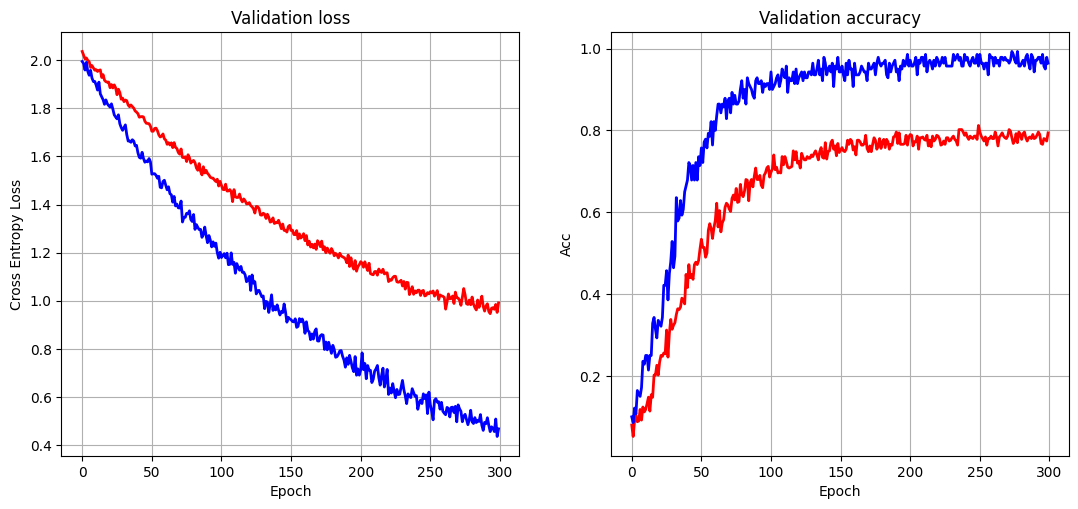

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red")
axs[0].plot(training_loss, linewidth=2, color="blue")
axs[0].set_title("Validation loss")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].set_xlabel("Epoch")
axs[0].grid()

axs[1].plot(validation_acc, linewidth=2, color="red")
axs[1].plot(training_acc, linewidth=2, color="blue")
axs[1].set_title("Validation accuracy")
axs[1].set_ylabel("Acc")
axs[1].set_xlabel("Epoch")
axs[1].grid()

plt.show()

学習後のfeatureがラベルごとにかたまっている見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

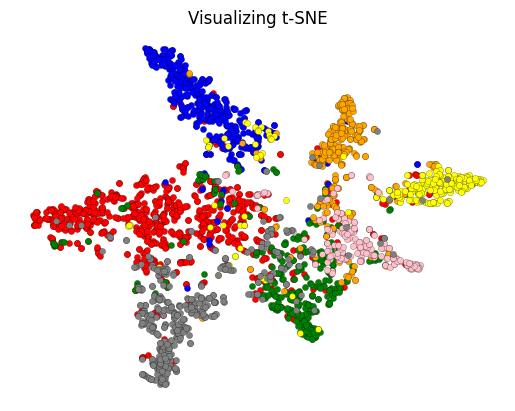

In [ ]:
visualize_embedding_tSNE(labels, y_pred, num_classes)